# Noise2Void - 2D Example for SEM data

__Note:__ This notebook expects a trained model and will only work if you have executed the `01_training.ipynb` beforehand.

In [27]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
import os
import glob

## Load the Network

In [34]:
# List the files to analyze
input_folder = '/dodrio/scratch/projects/2024_300/training/n2v/'
output_folder = '/dodrio/scractch/projects/2024_300/<YOUR_NAME>/nv2' #TO CHANGE
model_folder = os.path.join(output_folder, 'model')
file_extension = 'tif'

In [35]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
model_name = 'n2v_2D_sem'
#basedir = 'models'
model = N2V(config=None, name=model_name, basedir=model_folder)

Loading network weights from 'weights_best.h5'.


In [ ]:
# In case you do not want to load the weights that lead to lowest validation loss during 
# training but the latest computed weights, you can execute the following line:

# model.load_weights('weights_last.h5')

## Prediction
Here we will simply use the same data as during training and denoise it using our network.

In [41]:
files = glob.glob(input_folder+'/*.'+file_extension)
files.sort()

if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

img=None
pred=None

stack_min= np.finfo(np.float32).max
stack_max = -1

for file in files:
    print(file)
    basename = os.path.basename(file)
    basename_witout_extension = basename[0:-(len(file_extension)+1)]
    img = imread(file)

    # Here we process the data.
    # The 'n_tiles' parameter can be used if images are too big for the GPU memory.
    # If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
    pred = model.predict(img, axes='YX', n_tiles=(2,1))

    min = pred.min()
    if(min<stack_min):
        stack_min=min
    max = pred.max()
    if(max>stack_max):
        stack_max=max

    save_tiff_imagej_compatible(os.path.join(output_folder,basename_witout_extension+'_denoised.tif'), pred, 'YX')

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0000.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0001.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 27.02it/s]


C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0002.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 28.91it/s]


C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0003.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 2/2 [00:00<00:00, 27.81it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0004.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 2/2 [00:00<00:00, 27.86it/s]


C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0005.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 2/2 [00:00<00:00, 26.49it/s]


C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0006.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 2/2 [00:00<00:00, 26.59it/s]


C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0007.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 2/2 [00:00<00:00, 22.19it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0008.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 2/2 [00:00<00:00, 26.95it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0009.tif
The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 25.87it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0010.tif


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1/2 [00:00<00:00, 992.50it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 2/2 [00:00<00:00, 22.64it/s] 

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0011.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 25.59it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0012.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 2/2 [00:00<00:00, 23.93it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0013.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 2/2 [00:00<00:00, 24.08it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0014.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 2/2 [00:00<00:00, 25.50it/s]


C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0015.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 2/2 [00:00<00:00, 24.81it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0016.tif
The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 2/2 [00:00<00:00, 23.47it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0017.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 24.29it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0018.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 24.06it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0019.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 2/2 [00:00<00:00, 22.68it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0020.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 2/2 [00:00<00:00, 24.94it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0021.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 24.78it/s]


C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0022.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 2/2 [00:00<00:00, 18.76it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0023.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 24.38it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0024.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00, 24.42it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0025.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 2/2 [00:00<00:00, 24.23it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0026.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0027.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step



 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 2/2 [00:00<00:00, 21.73it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0028.tif
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 2/2 [00:00<00:00, 21.16it/s]

C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\EM327_FP2_2311_cropped0029.tif
The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1/2 [00:00<00:00, 996.51it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 2/2 [00:00<00:00, 23.05it/s] 

Max:219.30313
Min:5.368759


In [42]:
#Convert to 16bits
print('Max:'+str(stack_max))
print('Min:'+str(stack_min))

rescale_folder = os.path.join(output_folder, '16bits')

files = glob.glob(output_folder+'/*.'+file_extension)
files.sort()

if os.path.isdir(rescale_folder)==False:
    os.makedirs(rescale_folder)

for file in files:
    print(file)
    basename = os.path.basename(file)
    basename_witout_extension = basename[0:-(len(file_extension)+1)]
    pred = imread(file)
    pred_16 = (pred / stack_max) * 65536 #2^16
    pred_16 = pred_16.astype(np.uint16) 
    save_tiff_imagej_compatible(os.path.join(rescale_folder,basename_witout_extension+'.tif'), pred_16, 'YX')

Max:219.30313
Min:5.368759
C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\output\EM327_FP2_2311_cropped0000_denoised.tif
C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\output\EM327_FP2_2311_cropped0001_denoised.tif
C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\output\EM327_FP2_2311_cropped0002_denoised.tif
C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\output\EM327_FP2_2311_cropped0003_denoised.tif
C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\output\EM327_FP2_2311_cropped0004_denoised.tif
C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Python_image_analysis\dataset\denoising\internal\output\EM327_FP2_2311_cropped0005_denoised.tif
C:\Users\u0094799\Documents\Projects\PRESENTATIONS\2024_Pytho

### Show results on data

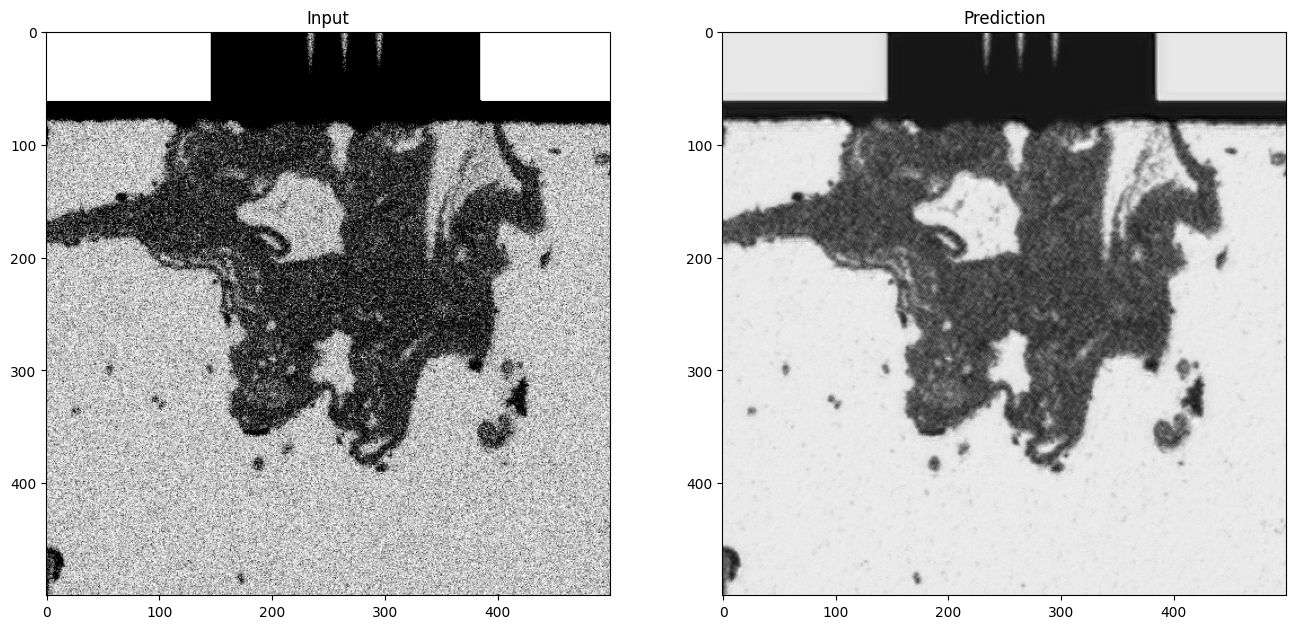

In [33]:
# Let's look at the results.
# Show a 500x500 crop of the image before and after
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img[:500:,:500],cmap="gray")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred[:500:,:500],cmap="gray")
plt.title('Prediction');